In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

C:\Users\Irfan\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("TensorFlow version:", keras.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.10.0
NumPy version: 1.26.0


In [3]:
gRNA_LENGTH = 28
input_length = 33

In [4]:
dct_ohc_seq = {'A': [1, 0, 0, 0],
               'C': [0, 1, 0, 0],
               'G': [0, 0, 1, 0],
               'T': [0, 0, 0, 1],
               'N': [0, 0, 0, 0]}

def seq_one_hot_code(seq):
    seq = seq.upper()
    lst_seq = list(seq)
    return [dct_ohc_seq[i] for i in lst_seq]

In [5]:
file = 'BS6204_input.10WINDOW.csv'
WINDOW_LENGTH_ORIGINAL=10
LENGTH_TO_TEST=3
INPUT_LENGTH=LENGTH_TO_TEST + gRNA_LENGTH + LENGTH_TO_TEST
ACTUAL_LENGTH = WINDOW_LENGTH_ORIGINAL + gRNA_LENGTH + WINDOW_LENGTH_ORIGINAL

class inputObject:
    
    def __init__(self, col):
        self.seq_id = col[0]
        assert len(col[1]) == ACTUAL_LENGTH
        self.seq = col[1][WINDOW_LENGTH_ORIGINAL-LENGTH_TO_TEST:WINDOW_LENGTH_ORIGINAL+gRNA_LENGTH+LENGTH_TO_TEST]
        #self.quartile = int(col[2].replace('Q',''))
        #self.guideScore = float(col[3])
        self.quartile = None
        self.guideScore = None

seq_dict = {}
with open(file, 'r') as f:
    next(f)
    for line in f:
        col = line.strip('\n').split(',')
        seq_id = col[0]
        seq_dict[seq_id] = inputObject(col)

# Update Using Mean-Normalized Score2
file2 = "MeanAdjustedScores.csv"
with open(file2, 'r') as f:
    next(f)
    for line in f:
        col = [i.replace('"','').replace('"','') for i in line.strip('\n').split(',')]
        seq_id = col[0] 
        seq_dict[seq_id].quartile = int(col[11].replace('Q',''))
        seq_dict[seq_id].guideScore = float(col[10])

In [6]:
seq   = []
score = []
quart = []

for k,v in seq_dict.items():
    seq.append(v.seq)
    score.append(v.guideScore)
    quart.append(v.quartile-1)
    
target_data = np.array(score)
quart_data  = np.array(quart)
    
nt_dict = {'A':1, 'C':2, 'G':3, 'T':4, 'N':0}    

X_train_seq = [seq_one_hot_code(s) for s in seq]
# X_train_seq = [[nt_dict[s] for s in s1] for s1 in seq]
X_train_arr_seq = np.array(X_train_seq)

quart = [0 if i<2 else 1 for i in quart]
quart_data = np.array(quart)
num_classes = 2
one_hot_labels = to_categorical(quart_data, num_classes)

In [7]:
print(quart.count(0), quart.count(1))

225 225


In [8]:
from keras.layers import Input, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Dense, TimeDistributed, Flatten, LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers import concatenate
from keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, Reshape

# Sequential model for sequence input
seq_model = Sequential()
seq_model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(INPUT_LENGTH, 4, 1))) # 2 + 28 RNA + 2
seq_model.add(BatchNormalization())
seq_model.add(Dropout(0.3))
seq_model.add(MaxPooling2D((2, 2)))
seq_model.add(Flatten())

# seq_model.add(Reshape((INPUT_LENGTH, 1), input_shape=(INPUT_LENGTH,)))  # Reshape input

# # Add a Bidirectional LSTM layer
# seq_model.add(Bidirectional(LSTM(units=24, return_sequences=True, activation='relu'))) # You can adjust the number of units as needed
# seq_model.add(Dropout(0.3))
seq_model.add(Dense(64, activation='relu'))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(64, activation='relu'))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(32, activation='relu'))
seq_model.add(Dropout(0.3))
# seq_model.add(Flatten())

NN_output  = Dense(2, activation='softmax')(seq_model.output)

# Create the final model
NN_model = Model(inputs=[seq_model.input], outputs=NN_output)


In [9]:
NN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 34, 4, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 34, 4, 8)          80        
                                                                 
 batch_normalization (BatchN  (None, 34, 4, 8)         32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 34, 4, 8)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 2, 8)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 272)               0     

Code for Model Training

In [10]:
from keras import backend as K
import tensorflow as tf
from keras.losses import binary_crossentropy

In [11]:
def custom_true_positive_metric(y_true, y_pred):
    # Calculate True Positives (TP)
    true_positives = tf.math.reduce_sum(tf.math.round(tf.math.multiply(y_true, y_pred)))
    
    # Return True Positives as the custom metric
    return true_positives

def custom_loss(y_true, y_pred):
    # Weight for False Negatives (increase this value to prioritize TP)
    weight_fn = 10  # You can adjust this value as needed

    # Ensure y_true and y_pred are compatible for binary classification
    y_true = tf.cast(y_true, tf.float32)

    # Calculate the binary cross-entropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Calculate the number of False Negatives (FN)
    fn = tf.reduce_sum(tf.maximum(y_true - y_pred, 0))

    # Modify the loss by applying the weight to FN
    custom_loss = bce + weight_fn * fn

    return custom_loss

In [12]:
# let's define more parameters
# yinning.huang@gmail.com
batch_size = 128
num_epochs = 100

from keras.optimizers import SGD, Adam  # or any other optimizer you are using

# Define your optimizer with a custom learning rate
custom_lr = 0.0025  # Change this value to the desired learning rate 
custom_optimizer = Adam(learning_rate=custom_lr)


NN_model.compile(loss      = custom_loss, # binary_crossentropy,
                 optimizer = custom_optimizer,
                 metrics   = [custom_true_positive_metric, "accuracy"]) # ["accuracy"]

In [13]:
X_train_seq_CNN = np.reshape(X_train_arr_seq, (len(X_train_arr_seq), INPUT_LENGTH, 4, 1)) 
# X_train_seq_CNN = np.reshape(X_train_arr_seq, (len(X_train_arr_seq), INPUT_LENGTH)) 

In [14]:
history = NN_model.fit([X_train_seq_CNN], one_hot_labels, epochs=num_epochs, batch_size=batch_size, validation_split = 0.2)

Epoch 1/100
3/3 [==============================] - 1s 105ms/step - loss: 584.5690 - custom_true_positive_metric: 63.6667 - accuracy: 0.5306 - val_loss: 463.2641 - val_custom_true_positive_metric: 37.0000 - val_accuracy: 0.4111
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 590.9720 - custom_true_positive_metric: 60.0000 - accuracy: 0.5000 - val_loss: 475.6562 - val_custom_true_positive_metric: 40.0000 - val_accuracy: 0.4444
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 591.3129 - custom_true_positive_metric: 61.0000 - accuracy: 0.5083 - val_loss: 475.2346 - val_custom_true_positive_metric: 39.0000 - val_accuracy: 0.4333
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 584.8948 - custom_true_positive_metric: 60.6667 - accuracy: 0.5056 - val_loss: 475.1523 - val_custom_true_positive_metric: 39.0000 - val_accuracy: 0.4333
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 584.1202 - custom_true_

3/3 [==============================] - 0s 18ms/step - loss: 289.1460 - custom_true_positive_metric: 92.3333 - accuracy: 0.7694 - val_loss: 433.9832 - val_custom_true_positive_metric: 48.0000 - val_accuracy: 0.5333
Epoch 74/100
3/3 [==============================] - 0s 18ms/step - loss: 267.8601 - custom_true_positive_metric: 94.3333 - accuracy: 0.7861 - val_loss: 433.9503 - val_custom_true_positive_metric: 47.0000 - val_accuracy: 0.5222
Epoch 75/100
3/3 [==============================] - 0s 17ms/step - loss: 244.8813 - custom_true_positive_metric: 96.3333 - accuracy: 0.8028 - val_loss: 432.7947 - val_custom_true_positive_metric: 46.0000 - val_accuracy: 0.5111
Epoch 76/100
3/3 [==============================] - 0s 19ms/step - loss: 306.9401 - custom_true_positive_metric: 89.3333 - accuracy: 0.7444 - val_loss: 435.6954 - val_custom_true_positive_metric: 47.0000 - val_accuracy: 0.5222
Epoch 77/100
3/3 [==============================] - 0s 17ms/step - loss: 295.0109 - custom_true_positive_

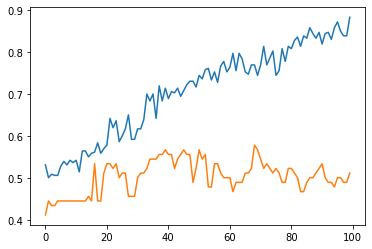

In [15]:
# plot accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

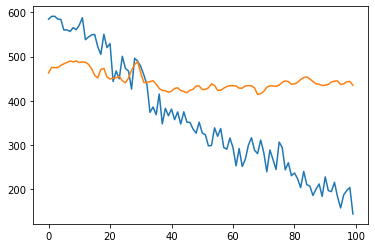

In [16]:
# plot losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [17]:
predicted_values_for_X_train = NN_model.predict([X_train_seq_CNN])
predicted_values_for_X_train

15/15 [==============================] - 0s 2ms/step


array([[9.95823860e-01, 4.17610025e-03],
       [9.99450743e-01, 5.49273915e-04],
       [9.99240398e-01, 7.59641698e-04],
       [9.82027888e-01, 1.79720558e-02],
       [8.15986574e-01, 1.84013382e-01],
       [8.03928316e-01, 1.96071669e-01],
       [6.42230958e-02, 9.35776889e-01],
       [9.98874605e-01, 1.12534792e-03],
       [9.93251860e-01, 6.74814032e-03],
       [4.26170677e-02, 9.57382858e-01],
       [9.80763555e-01, 1.92363895e-02],
       [9.88503158e-01, 1.14968671e-02],
       [9.99773324e-01, 2.26672419e-04],
       [7.88643062e-01, 2.11356938e-01],
       [3.35598706e-05, 9.99966383e-01],
       [6.75056055e-02, 9.32494402e-01],
       [9.94861186e-01, 5.13885077e-03],
       [3.16393329e-03, 9.96836066e-01],
       [9.99011636e-01, 9.88283195e-04],
       [3.88534216e-04, 9.99611437e-01],
       [2.89663230e-03, 9.97103393e-01],
       [9.99507070e-01, 4.92945081e-04],
       [9.80214238e-01, 1.97857041e-02],
       [3.61576420e-03, 9.96384263e-01],
       [9.452781

In [18]:
predicted_labels = np.argmax(predicted_values_for_X_train, axis=1)
poor_count = 0
for c, (i,j) in enumerate(zip(predicted_labels, quart_data)):
    poor = 'Poor' if i == 1 and j == 0 else 'Okay'
    if poor == 'Poor':
        poor_count += 1
    print (c, "Pred", i, "True", j, i==j, poor)

0 Pred 0 True 0 True Okay
1 Pred 0 True 0 True Okay
2 Pred 0 True 0 True Okay
3 Pred 0 True 0 True Okay
4 Pred 0 True 0 True Okay
5 Pred 0 True 0 True Okay
6 Pred 1 True 0 False Poor
7 Pred 0 True 0 True Okay
8 Pred 0 True 0 True Okay
9 Pred 1 True 1 True Okay
10 Pred 0 True 0 True Okay
11 Pred 0 True 0 True Okay
12 Pred 0 True 0 True Okay
13 Pred 0 True 0 True Okay
14 Pred 1 True 1 True Okay
15 Pred 1 True 1 True Okay
16 Pred 0 True 0 True Okay
17 Pred 1 True 1 True Okay
18 Pred 0 True 0 True Okay
19 Pred 1 True 1 True Okay
20 Pred 1 True 1 True Okay
21 Pred 0 True 0 True Okay
22 Pred 0 True 0 True Okay
23 Pred 1 True 1 True Okay
24 Pred 0 True 0 True Okay
25 Pred 1 True 1 True Okay
26 Pred 1 True 1 True Okay
27 Pred 1 True 1 True Okay
28 Pred 1 True 1 True Okay
29 Pred 0 True 0 True Okay
30 Pred 1 True 1 True Okay
31 Pred 1 True 1 True Okay
32 Pred 1 True 1 True Okay
33 Pred 0 True 0 True Okay
34 Pred 1 True 1 True Okay
35 Pred 0 True 0 True Okay
36 Pred 1 True 1 True Okay
37 Pred 1 

343 Pred 0 True 0 True Okay
344 Pred 0 True 1 False Okay
345 Pred 1 True 1 True Okay
346 Pred 1 True 1 True Okay
347 Pred 1 True 1 True Okay
348 Pred 1 True 1 True Okay
349 Pred 1 True 1 True Okay
350 Pred 1 True 1 True Okay
351 Pred 0 True 0 True Okay
352 Pred 1 True 1 True Okay
353 Pred 1 True 1 True Okay
354 Pred 1 True 1 True Okay
355 Pred 0 True 0 True Okay
356 Pred 0 True 0 True Okay
357 Pred 1 True 1 True Okay
358 Pred 1 True 1 True Okay
359 Pred 1 True 1 True Okay
360 Pred 1 True 1 True Okay
361 Pred 0 True 1 False Okay
362 Pred 1 True 1 True Okay
363 Pred 0 True 1 False Okay
364 Pred 1 True 1 True Okay
365 Pred 0 True 1 False Okay
366 Pred 0 True 0 True Okay
367 Pred 1 True 1 True Okay
368 Pred 0 True 0 True Okay
369 Pred 0 True 1 False Okay
370 Pred 1 True 0 False Poor
371 Pred 0 True 0 True Okay
372 Pred 0 True 0 True Okay
373 Pred 0 True 1 False Okay
374 Pred 0 True 1 False Okay
375 Pred 0 True 0 True Okay
376 Pred 0 True 0 True Okay
377 Pred 0 True 1 False Okay
378 Pred 0 

In [19]:
print (poor_count, len(quart_data))

31 450


In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(quart_data,predicted_labels)
cm

array([[194,  31],
       [ 38, 187]], dtype=int64)

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(quart_data,predicted_labels)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(quart_data,predicted_labels)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(quart_data,predicted_labels)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(quart_data,predicted_labels)
print('F1 score: %f' % f1)

Accuracy: 0.846667
Precision: 0.857798
Recall: 0.831111
F1 score: 0.844244


In [21]:
class inputTestObject:
    
    def __init__(self, col):
        self.seq_id = col[0]
        assert len(col[11]) == ACTUAL_LENGTH, len(col[11])
        self.seq = col[11][WINDOW_LENGTH_ORIGINAL-LENGTH_TO_TEST:WINDOW_LENGTH_ORIGINAL+gRNA_LENGTH+LENGTH_TO_TEST]
        self.seq_input = np.array([nt_dict[s] for s in self.seq])
        self.quartile = None
        self.guideScore = None


file_test = 'adjusted_raw_data.test.csv'
seq_dict_test = {}
with open(file_test, 'r') as f:
    next(f)
    for line in f:
        col = line.strip('\n').split(',')
        seq_id = col[0]
        seq_dict_test[seq_id] = inputTestObject(col)
        seq_dict_test[seq_id].quartile = int(col[10].replace('Q',''))
        seq_dict_test[seq_id].guideScore = float(col[9])


In [23]:
seq_test   = []
score_test = []
quart_test = []

for k,v in seq_dict_test.items():
    seq_test.append(v.seq)
    score_test.append(v.guideScore)
    quart_test.append(v.quartile)
    
quart_data_test  = np.array(quart_test)
    
nt_dict = {'A':1, 'C':2, 'G':3, 'T':4, 'N':0}    

X_test_seq = [seq_one_hot_code(s) for s in seq_test]
# X_train_seq = [[nt_dict[s] for s in s1] for s1 in seq]
X_test_arr_seq = np.array(X_test_seq)

X_test_seq_CNN = np.reshape(X_test_arr_seq, (len(X_test_arr_seq), INPUT_LENGTH, 4, 1)) 

quart_data_test = np.array(quart_data_test)
num_classes = 2
one_hot_labels_test = to_categorical(quart_data_test, num_classes)

predicted_values_for_X_test = NN_model.predict([X_test_seq_CNN])
predicted_labels_test = np.argmax(predicted_values_for_X_test, axis=1)
cm = confusion_matrix(quart_data_test,predicted_labels_test)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(quart_data_test,predicted_labels_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(quart_data_test,predicted_labels_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(quart_data_test,predicted_labels_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(quart_data_test,predicted_labels_test)
print('F1 score: %f' % f1)

4/4 [==============================] - 0s 2ms/step
Accuracy: 0.571429
Precision: 0.533333
Recall: 0.500000
F1 score: 0.516129
